## DETECTING EARLY ALZHEIMER'S USING MRI LONGITUDINAl DATA

In [1]:
%matplotlib inline

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import os
import pandas as pd
import matplotlib.patches as mpatches
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, roc_curve, roc_auc_score, auc
from sklearn.preprocessing import minmax_scale
from skimage.feature import hog
from skimage import io
from skimage.filters import threshold_sauvola
from skimage.color import rgb2gray
from skimage.transform import resize
from scipy import ndimage
from skimage import measure
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SVMSMOTE
plt.rcParams['figure.figsize'] = (15, 6)
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler 

In [4]:
df = pd.read_csv('oasis_longitudinal.csv')

We are going to use the MRI longitudinal data. The supervised classification approach will be applied in this project because we plan to predict the binary results of Alzheimer disease (yes or no).

The classifiers will be used and compared: random forest, decision tree, logistic regression, and k-nearest neighbour classifier.

Performance metrics will be accuracy, recall, and ROC AUC.
Validation of hyperparameters will be also applied for each classifier.

The original dataset consists of 3 classes: Demented, Nondemented, and Converted (initially were classified as nondemented but at the second or third visit were classified as Demented). For sake of the simplification of the analysis the class "Converted" was changed to "Demented".

## Pre-processing the data

In [5]:
# Loading MRI data. 
# Specify the path to your CSV file
file_path = 'oasis_longitudinal.csv'

# Load data from the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)

# use first visit data only because the diagnoses were given at the first visit 
df = df.loc[df['Visit']==1] 

# reset index after filtering first visit data
df = df.reset_index(drop=True) 

# M/F column change to 0,1
df['M/F'] = df['M/F'].replace(['F','M'], [0,1]) 

# Target variable change Converted to Demented
df['Group'] = df['Group'].replace(['Converted'], ['Demented']) 

# Target variable change to 0=Nondemented,1=demented
df['Group'] = df['Group'].replace(['Demented', 'Nondemented'], [1,0]) 

# Drop unnecessary columns
df = df.drop(['MRI ID', 'Visit', 'Hand'], axis=1) 

#check the overall number of the observations
num_observations = len(df)
print("Number of Observations:", num_observations)

# Check missing values by each column
pd.isnull(df).sum() 
# The column, SES has 8 missing values

Number of Observations: 150


Subject ID    0
Group         0
MR Delay      0
M/F           0
Age           0
EDUC          0
SES           8
MMSE          0
CDR           0
eTIV          0
nWBV          0
ASF           0
dtype: int64

In [6]:
# Dropped the 8 rows with missing values in the column, SES
df_dropna = df.dropna(axis=0, how='any')
print(pd.isnull(df_dropna).sum())

print()

num_observations = len(df_dropna)
print("Number of Observations:", num_observations)

Subject ID    0
Group         0
MR Delay      0
M/F           0
Age           0
EDUC          0
SES           0
MMSE          0
CDR           0
eTIV          0
nWBV          0
ASF           0
dtype: int64

Number of Observations: 142


The scaling and dividing the data into 3 sets (training (50%), validation (25%), test (25%)):

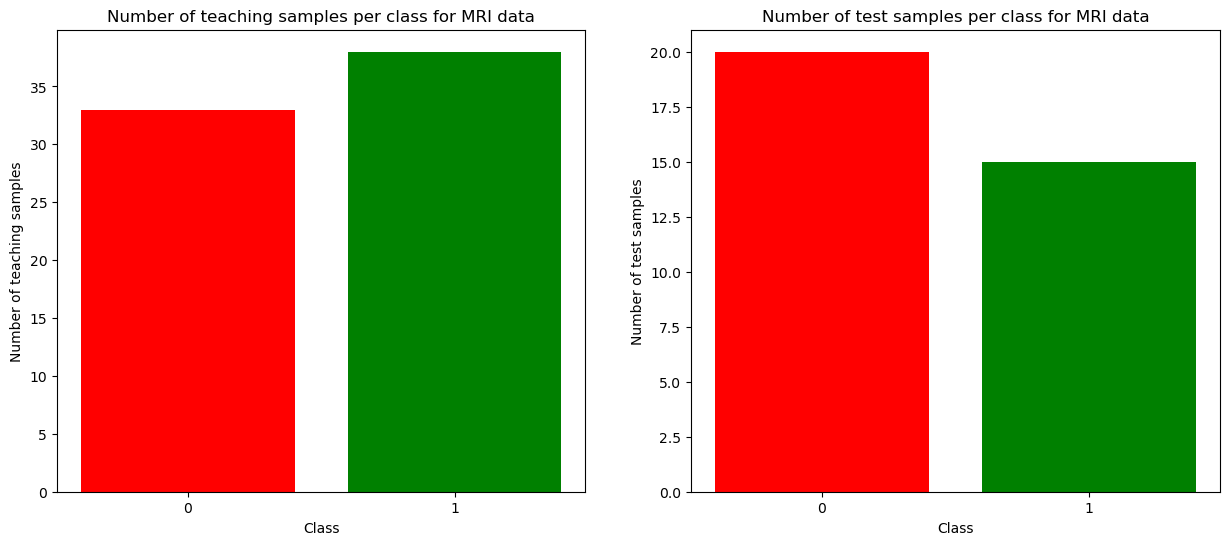

Teaching data class 0 has 33 samples and in class 1 there are 38 samples
Test data class 0 has 20 samples and in class 1 there are 15 samples


In [7]:
# classes for the model
Y = df_dropna['Group'].values

# Features we use
X = df_dropna[['M/F', 'Age', 'EDUC', 'SES', 'MMSE', 'eTIV', 'nWBV', 'ASF']]

# Split the data into training (50%), validation (25%), test (25%)
data_teaching, data_tmp, classes_teaching, classes_tmp = train_test_split(X, Y, test_size=0.5, random_state=0)
data_test, data_validate, classes_test, classes_validate = train_test_split(data_tmp, classes_tmp, test_size=0.5, random_state=0)

# Feature scaling for teaching and validation data separately in order to prevent the train-test contamination (data leakage)
scaler = MinMaxScaler().fit(data_teaching)
data_validate = scaler.transform(data_validate)
data_teaching = scaler.transform(data_teaching)

# Feature scaling for the test data only
scaler_1 = MinMaxScaler().fit(data_test)
data_test = scaler.transform(data_test)

# Illustrate the imbalance of teaching data with a bar chart
plt.subplot(121)
categories_teaching, quantities_teaching = np.unique(classes_teaching.astype('U'), return_counts=True)
plt.bar(categories_teaching, quantities_teaching, color=['red','green'])
plt.xlabel('Class')
plt.ylabel('Number of teaching samples')
plt.title('Number of teaching samples per class for MRI data')

# Illustrate the imbalance of test data with a bar chart
plt.subplot(122)
categories_test, quantities_test = np.unique(classes_test.astype('U'), return_counts=True)
plt.bar(categories_test, quantities_test, color=['red','green'])
plt.xlabel('Class')
plt.ylabel('Number of test samples')
plt.title('Number of test samples per class for MRI data')
plt.show()

# Print the numbers of samples of teaching data and test data per category 
print('Teaching data class {} has {} samples and in class {} there are {} samples'.format(categories_teaching[0], quantities_teaching[0], categories_teaching[1], quantities_teaching[1]))
print('Test data class {} has {} samples and in class {} there are {} samples'.format(categories_test[0], quantities_test[0], categories_test[1], quantities_test[1]))

## Validation of the k-nearest neigbors classifier

Start validation on the number of neighbors $ k $ of the k-nearest neighbor classifier. Go through the loop $ k $ values 1-33 every one step. Then the effect of the value of $ k $ on the classification accuracy is plotted on the graph and the best value of $ k $ is selected from the graph. 

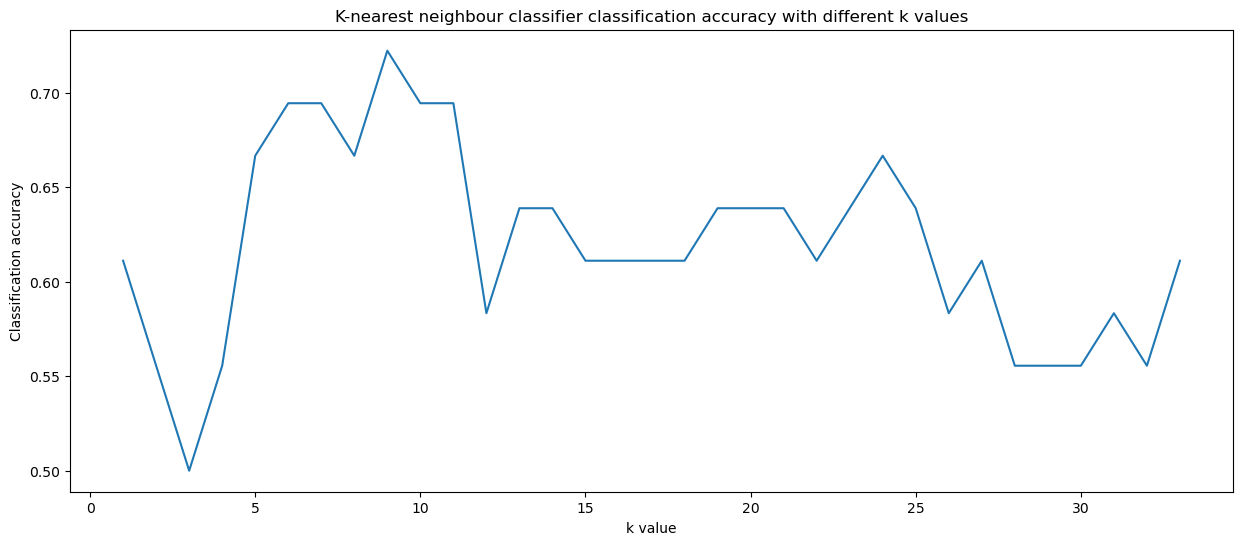

Best value k value for k-nearest neighbour classifier: 9


In [8]:
# Perform validation of k-nearest neighbour classifier

# Loop through values from 1 to 33 with step of 1
classification_accuracy_knn = []
k_values = range(1,34,1)
for k in k_values:
    classifier_knn = KNeighborsClassifier(n_neighbors=k).fit(data_teaching, classes_teaching)
    classification_accuracy_knn.append(accuracy_score(classes_validate, classifier_knn.predict(data_validate)))
    
# Plot a graph with different k values to see how it affects classification accuracy
plt.plot(k_values, classification_accuracy_knn)
plt.title('K-nearest neighbour classifier classification accuracy with different k values')
plt.xlabel('k value')
plt.ylabel('Classification accuracy')
plt.show()

# Finally choose best k value from graph
maximum_index_knn = np.argmax(classification_accuracy_knn)
print('Best value k value for k-nearest neighbour classifier: {}'.format(k_values[maximum_index_knn]))

## Validation of logistic regression classifier
Validation of the logistic regression using hyperparameter $C$. It regulates the intensity of the regularization of the classifier. Loop through $C$ values $10^{n}$, where $n$ is -5, -4, ..., 14, 15. Then plot the effect of the exponent value of $C$ on the classification accuracy and select the best value of $C$ from the graph. 

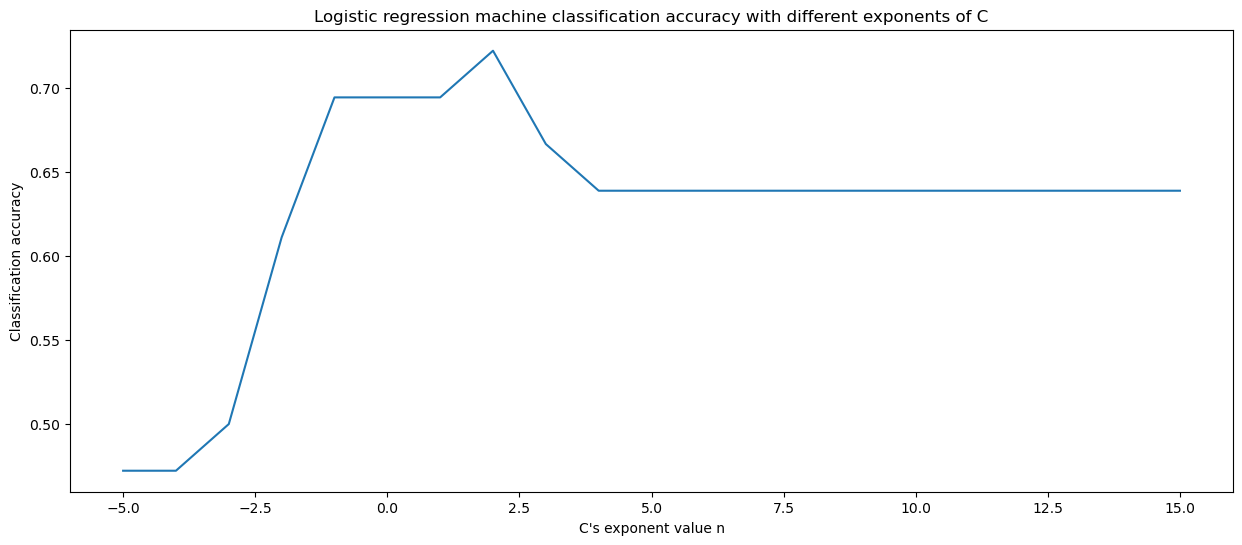

Best C value for logistic regression: 10^(2.0)


In [9]:
# Perform validation of logistic regression
# Loop through exponent values of C from -5 to 15
classification_accuracy_logistic_regression = []
n2 = np.array(range(-5,16),dtype=float)
C2_values = 10**n2
for C2 in C2_values:
    classifier_logistic_regression = LogisticRegression(C=C2, solver='liblinear', random_state=0).fit(data_teaching, classes_teaching)
    classification_accuracy_logistic_regression.append(accuracy_score(classes_validate, classifier_logistic_regression.predict(data_validate)))
    
# Plot a graph with different exponents of C to see how it affects classification accuracy
plt.plot(n2, classification_accuracy_logistic_regression)
plt.title('Logistic regression machine classification accuracy with different exponents of C')
plt.xlabel('C\'s exponent value n')
plt.ylabel('Classification accuracy')
plt.show()

# Choose best C value from graph
maximum_index_logistic_regression = np.argmax(classification_accuracy_logistic_regression)
print('Best C value for logistic regression: 10^({})'.format(n2[maximum_index_logistic_regression]))

Once the best values of the classifiers hyperparameters have been determined, we are going to teach them using the final classifiers. $k$ value - k-nearest neighbor, and the best exponent of $C$ for logistic regression $n_1$. 

## Validation of the decision tree classifier
Validation of the decision tree using the hyperparameter *maximum depth of the decision tree*. Go through the loop  max_depth  values 1-9 every step. Then the effect of the value of  max_depth  on the classification accuracy is plotted on the graph and the best value of  max_depth  is selected from the graph.

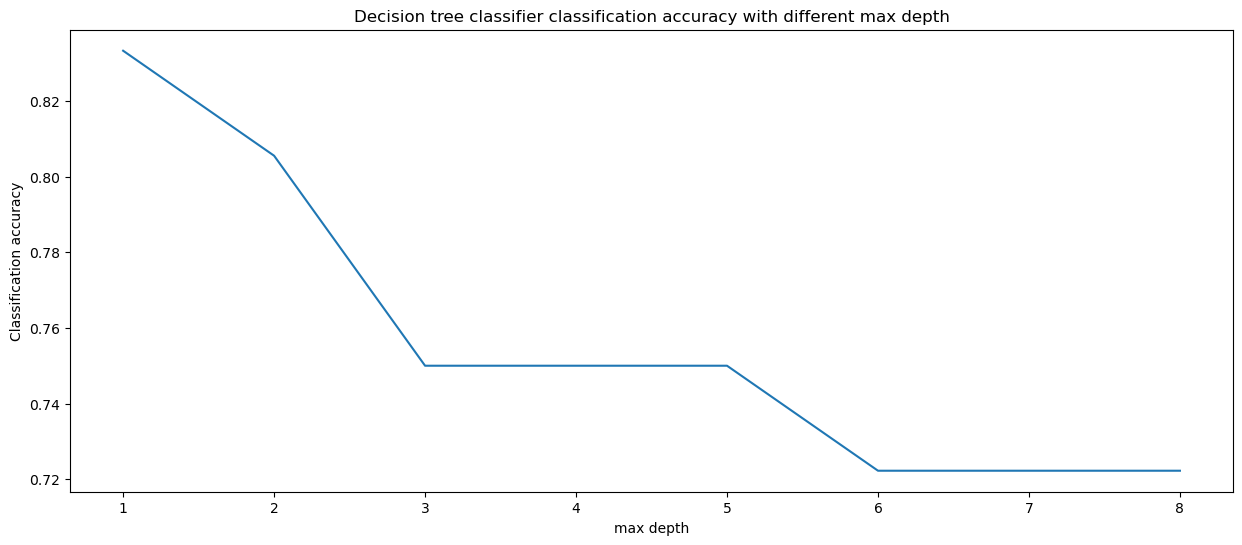

Best value max depth for deecision tree classifier: 1


In [10]:
# Loop through values from 1 to 33 with steps of 1
classification_accuracy_decision_tree = []
max_depth = range(1,9,1)
for n in max_depth:
    classifier_decision_tree = DecisionTreeClassifier(random_state=0, max_depth=n, criterion='gini').fit(data_teaching, classes_teaching)
    classification_accuracy_decision_tree.append(accuracy_score(classes_validate, classifier_decision_tree.predict(data_validate)))
    
# Plot a graph with different k values to see how it affects classification accuracy
plt.plot(max_depth, classification_accuracy_decision_tree)
plt.title('Decision tree classifier classification accuracy with different max depth')
plt.xlabel('max depth')
plt.ylabel('Classification accuracy')
plt.show()

# Finally choose best k value from graph
maximum_index_decision_tree = np.argmax(classification_accuracy_decision_tree)
print('Best value max depth for deecision tree classifier: {}'.format(max_depth[maximum_index_decision_tree]))

 ## Validation of the random forest classifier

Validation of the random forest using the hyperparameter *number of trees in the forest*. Go through the loop n_estimators values 1-400 every 10 steps. Then the effect of the value of n_estimators on the classification accuracy is plotted on the graph and the best value of n_estimators is selected from the graph.

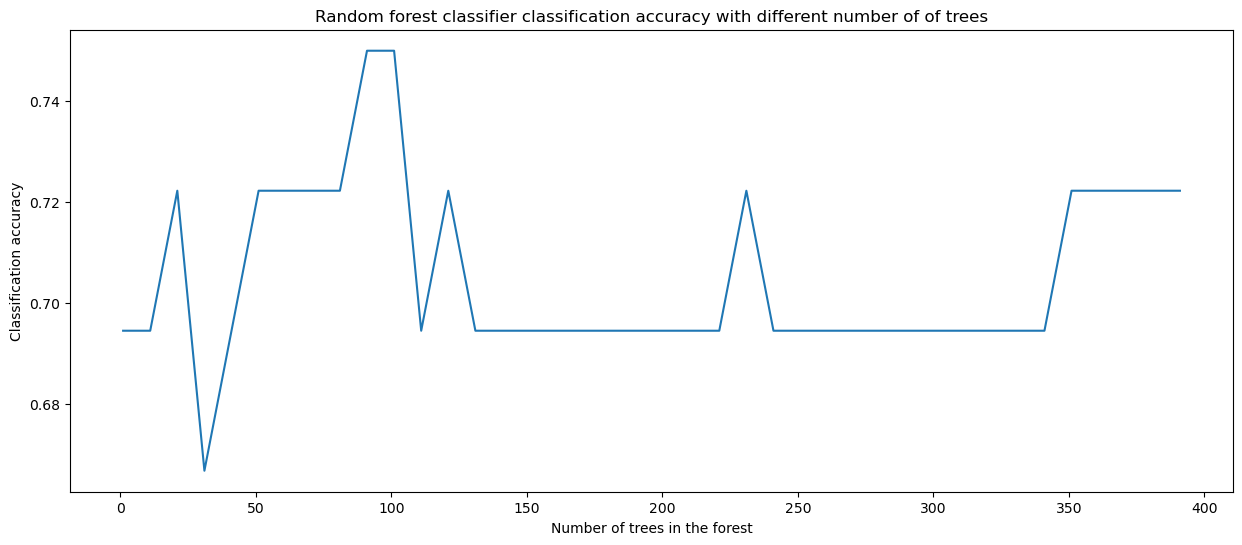

Best value number of estimators for random forest classifier: 91


In [11]:
# Loop through values from 1 to 33 with steps of 1
classification_accuracy_random_forest = []
n_est = range(1,400,10)
for n in n_est:
    classifier_random_forest = RandomForestClassifier(n_estimators=n, random_state=0).fit(data_teaching, classes_teaching)
    classification_accuracy_random_forest.append(accuracy_score(classes_validate, classifier_random_forest.predict(data_validate)))
    
# Plot a graph with different k values to see how it affects classification accuracy
plt.plot(n_est, classification_accuracy_random_forest)
plt.title('Random forest classifier classification accuracy with different number of of trees')
plt.xlabel('Number of trees in the forest')
plt.ylabel('Classification accuracy')
plt.show()

# Finally choose best k value from graph
maximum_index_random_forest = np.argmax(classification_accuracy_random_forest)
print('Best value number of estimators for random forest classifier: {}'.format(n_est[maximum_index_random_forest]))

In [12]:
# Teach classifier with best k and n1 values
k = 9
n1 = 2
n2 = 1
n3 = 91

classifier_knn_validate = KNeighborsClassifier(n_neighbors=k).fit(data_teaching, classes_teaching)
classifier_logistic_regression_validate = LogisticRegression(C=10**(n1), solver='liblinear', random_state=0).fit(data_teaching, classes_teaching)
classifier_decision_tree_validate = DecisionTreeClassifier(random_state=0, max_depth=n2, criterion='gini').fit(data_teaching, classes_teaching)
classifier_random_forest_validate = RandomForestClassifier(n_estimators=n3, random_state=0).fit(data_teaching, classes_teaching)

The dataset is balanced, with a roughly equal quantity of samples labeled as '1' and '0'. In medical diagnostics, our priority is achieving a high true positive rate to identify all patients with Alzheimer's disease at the earliest opportunity. Simultaneously, we aim to minimize the false positive rate to avoid misdiagnosing healthy adults as having dementia and initiating unnecessary medical interventions. Therefore, the ROC AUC (Receiver Operating Characteristic Area Under the Curve) serves as a key performance metric for evaluating model performance in this context.

Performance measures and confusion matrixes for all methods are presented below:

Classification accuracy for k-nearest neighbor: 0.7142857142857143
Recall/Sensitivity for k-nearest neighbor: 0.8

Classification accuracy for logistic regression: 0.7714285714285715
Recall/Sensitivity for logistic regression: 0.8666666666666667

Classification accuracy for decision tree: 0.8857142857142857
Recall/Sensitivity for decision tree: 0.7333333333333333

Classification accuracy for random forest: 0.5428571428571428
Recall/Sensitivity for random forest: 0.7333333333333333


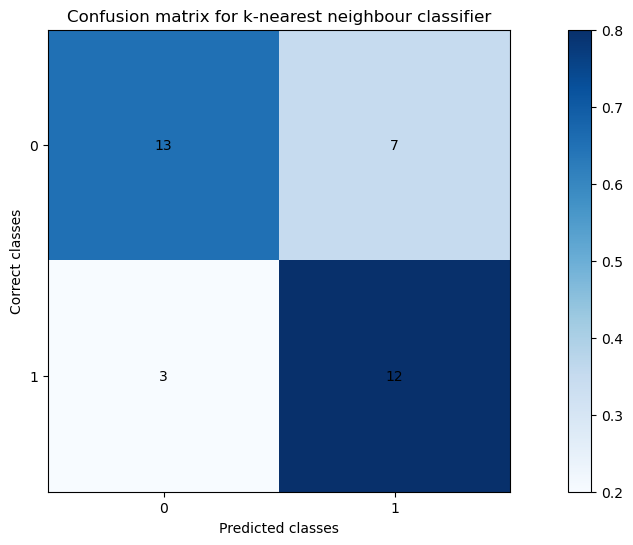

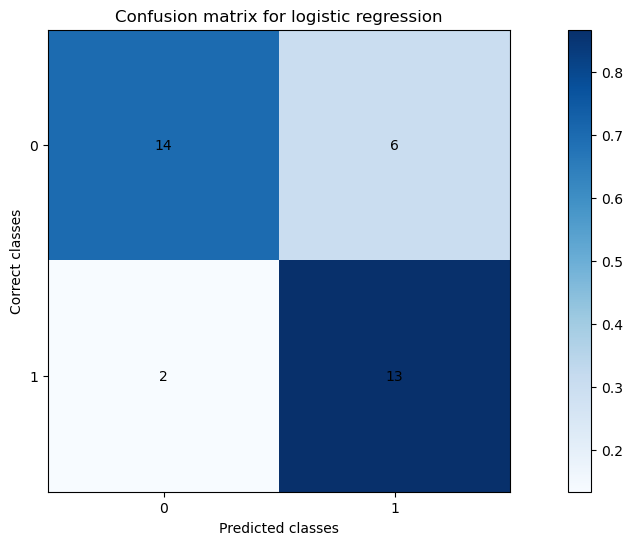

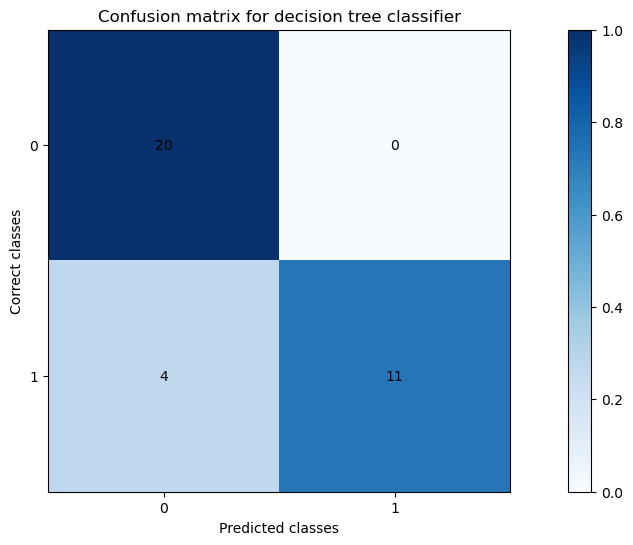

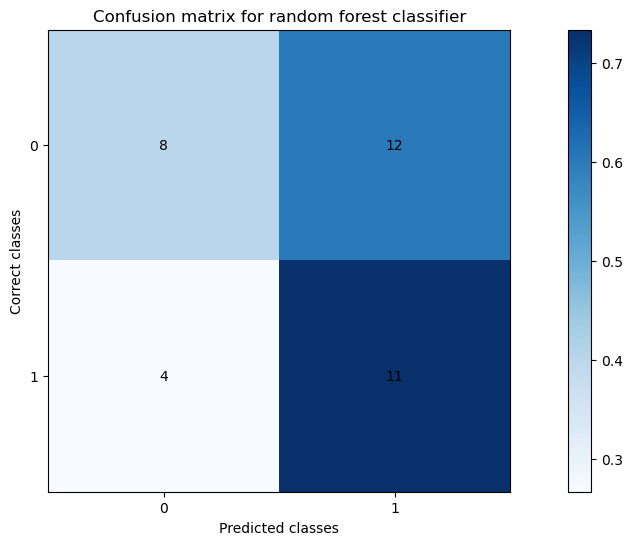

In [13]:
print('Classification accuracy for k-nearest neighbor: {}'.format(accuracy_score(classes_test, classifier_knn_validate.predict(data_test))))
print('Recall/Sensitivity for k-nearest neighbor: {}'.format(recall_score(classes_test, classifier_knn_validate.predict(data_test))))

print() 

print('Classification accuracy for logistic regression: {}'.format(accuracy_score(classes_test, classifier_logistic_regression_validate.predict(data_test))))
print('Recall/Sensitivity for logistic regression: {}'.format(recall_score(classes_test, classifier_logistic_regression_validate.predict(data_test))))

print() 

print('Classification accuracy for decision tree: {}'.format(accuracy_score(classes_test, classifier_decision_tree_validate.predict(data_test))))
print('Recall/Sensitivity for decision tree: {}'.format(recall_score(classes_test, classifier_decision_tree_validate.predict(data_test))))

print() 

print('Classification accuracy for random forest: {}'.format(accuracy_score(classes_test, classifier_random_forest_validate.predict(data_test))))
print('Recall/Sensitivity for random forest: {}'.format(recall_score(classes_test, classifier_random_forest_validate.predict(data_test))))

def print_confusion_matrix(conf_matrix, title):
    """
    This function prints confusion matrix
    """
    normalized_values = []
    for row in conf_matrix:
        summ = 0
        values = []
        summ = sum(row, 0)
        for value in row:
            values.append(float(value)/float(summ))
        normalized_values.append(values)
    fig = plt.figure()
    plt.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    colors = ax.imshow(np.array(normalized_values), cmap=plt.cm.Blues, interpolation='nearest')
    width, height = conf_matrix.shape
    for i in range(width):
        for j in range(height):
            ax.annotate(str(conf_matrix[i][j]), xy=(j, i), horizontalalignment='center', verticalalignment="center")
    fig.colorbar(colors)
    classes = '0123456789'
    plt.xticks(range(width), classes[:width])
    plt.yticks(range(height), classes[:height])
    plt.title(title)
    plt.xlabel("Predicted classes")
    plt.ylabel("Correct classes")
    
# Predict classes with validated k-nearest neighbour, place predicted classes in confusion matrix
print_confusion_matrix(confusion_matrix(classes_test, classifier_knn_validate.predict(data_test)), 'Confusion matrix for k-nearest neighbour classifier')

# Predict classes with validated logistic regression, place predicted classes in confusion matrix 
print_confusion_matrix(confusion_matrix(classes_test, classifier_logistic_regression_validate.predict(data_test)), 'Confusion matrix for logistic regression')

# Predict classes with validated decision tree, place predicted classes in confusion matrix
print_confusion_matrix(confusion_matrix(classes_test, classifier_decision_tree_validate.predict(data_test)), 'Confusion matrix for decision tree classifier')

# Predict classes with validated random forest, place predicted classes in confusion matrix
print_confusion_matrix(confusion_matrix(classes_test, classifier_random_forest_validate.predict(data_test)), 'Confusion matrix for random forest classifier')

plt.show()

ROC-curves for all 3 classifiers:

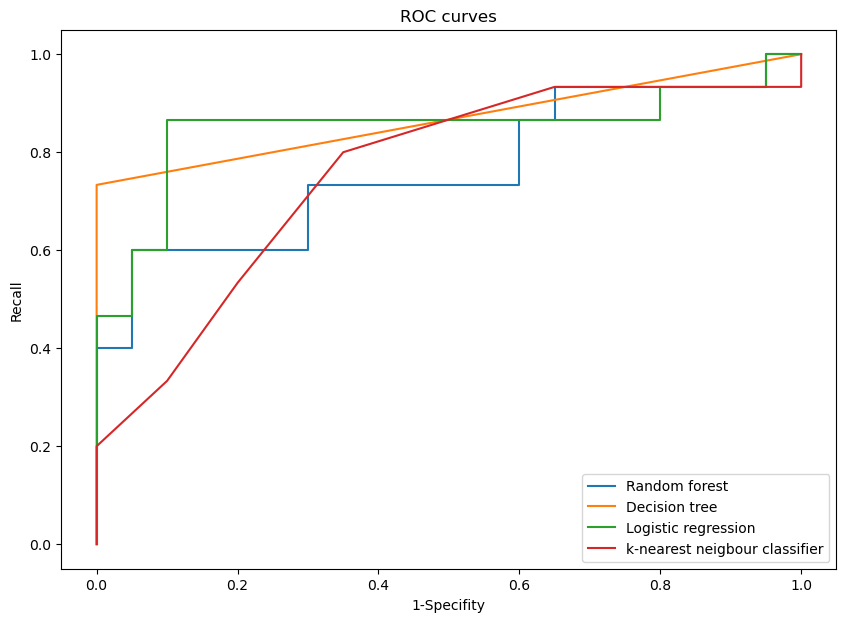

Random forest ROC AUC value: 0.763
Decision tree ROC AUC value: 0.867
Logistic regression ROC AUC value: 0.85
k-nearest neigbour  ROC AUC value: 0.757


In [14]:
# Calculate the posterior probabilities of the test data
posterior_probablity_random_forest = classifier_random_forest_validate.predict_proba(data_test)[:, 1]
posterior_probablity_decision_tree = classifier_decision_tree_validate.predict_proba(data_test)[:, 1]
posterior_probablity_logistic_regression = classifier_logistic_regression_validate.predict_proba(data_test)[:, 1]
posterior_probablity_knn = classifier_knn_validate.predict_proba(data_test)[:, 1]

# Calculate ROC-curves
fpr_random_forest, tpr_random_forest, _ = roc_curve(classes_test, posterior_probablity_random_forest)
fpr_decision_tree, tpr_decision_tree, _ = roc_curve(classes_test, posterior_probablity_decision_tree)
fpr_logistic_regression, tpr_logistic_regression, _ = roc_curve(classes_test, posterior_probablity_logistic_regression)
fpr_knn, tpr_knn, _ = roc_curve(classes_test, posterior_probablity_knn)

# Draw the ROC curves of all three classifiers on the graph 
plt.figure(figsize=(10,7))
plt.plot(fpr_random_forest, tpr_random_forest, label='Random forest')
plt.plot(fpr_decision_tree, tpr_decision_tree, label='Decision tree')
plt.plot(fpr_logistic_regression, tpr_logistic_regression, label='Logistic regression')
plt.plot(fpr_knn, tpr_knn, label='k-nearest neigbour classifier')
plt.xlabel('1-Specifity')
plt.ylabel('Recall')
plt.title('ROC curves')
plt.legend()
plt.show()

# Print ROC AUC values corresponding the ROC curves
print('Random forest ROC AUC value: {}'.format(round(roc_auc_score(classes_test, posterior_probablity_random_forest),3)))
print('Decision tree ROC AUC value: {}'.format(round(roc_auc_score(classes_test, posterior_probablity_decision_tree),3)))
print('Logistic regression ROC AUC value: {}'.format(round(roc_auc_score(classes_test, posterior_probablity_logistic_regression),3)))
print('k-nearest neigbour  ROC AUC value: {}'.format(round(roc_auc_score(classes_test, posterior_probablity_knn),3)))

Finally, all measurement values describing the performance of the classifiers are calculated and presented in a table. 

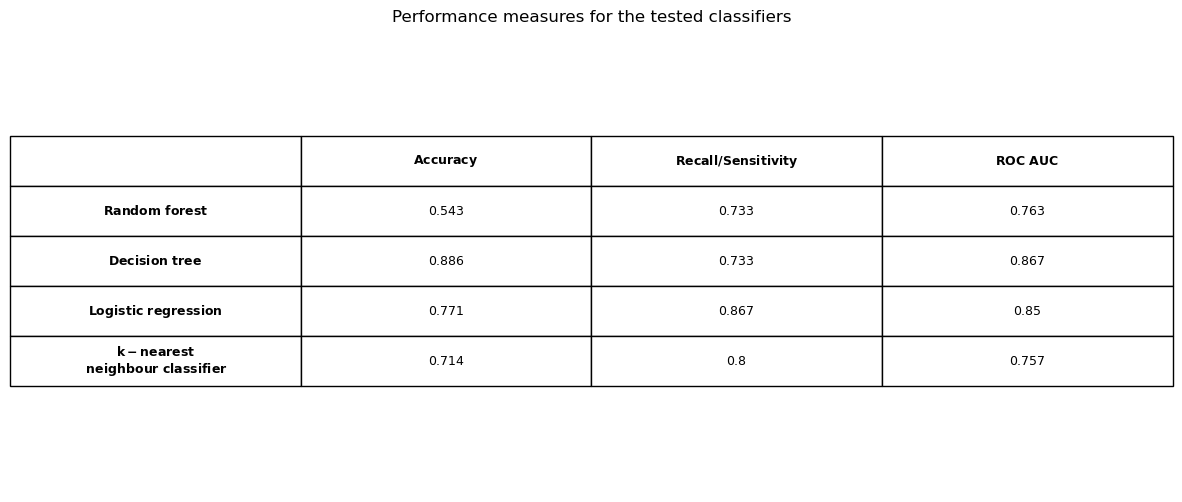

In [15]:
def calculate_measurement_values(data_test, classes_test, classifier, classifier_name):
    """
    This function calculates measurement values of classifier and saves them to the list
    """
    # Calculate accuracy, recall, ROC AUC 
    accuracy = round(accuracy_score(classes_test, classifier.predict(data_test)),3)
    recall = round(recall_score(classes_test, classifier.predict(data_test)),3)
    roc_auc = round(roc_auc_score(classes_test, classifier.predict_proba(data_test)[:, 1]),3)    
    return [classifier_name, accuracy, recall, roc_auc]

# A table is made to show the performance measurements 
measurement_values = []
measurement_values.append(['','$\\bf{Accuracy}$','$\\bf{Recall/Sensitivity}$','$\\bf{ROC\\ AUC}$'])
measurement_values.append(calculate_measurement_values(data_test, classes_test, classifier_random_forest_validate, '$\\bf{Random\\ forest}$'))
measurement_values.append(calculate_measurement_values(data_test, classes_test, classifier_decision_tree_validate, '$\\bf{Decision\\ tree}$'))
measurement_values.append(calculate_measurement_values(data_test, classes_test, classifier_logistic_regression_validate, '$\\bf{Logistic\\ regression}$'))
measurement_values.append(calculate_measurement_values(data_test, classes_test, classifier_knn_validate, '$\\bf{k-nearest}$\n $\\bf{neighbour\\ classifier}$'))

# print table
table = plt.gca().table(cellText=measurement_values, loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1,3)
plt.gca().axis('off')
plt.title('Performance measures for the tested classifiers')
plt.show()

**RESULTS: `The best classifier is decision tree (Accuracy = 88.6%, recall = 73.3%, ROC AUC = 86.7%).`**